# Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats import diagnostic
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl

In [2]:
data = pd.read_csv('TFP.csv', sep=',')
data.head()

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


In [3]:
#Let us see the columns of the dataset (in this case we have only 3 columns, but we could have
#a dataset with a lot of columns).
data.columns

Index(['isocode', 'year', 'rtfpna'], dtype='object')

In [4]:
#quantity of columns and rows in the dataset
print('meu dataset tem',data.shape[1],'colunas e',data.shape[0],'linhas')

meu dataset tem 3 colunas e 186 linhas


In [5]:
#table with columns, data type in each columns and percentage of nan data by column.
pd.DataFrame({'tipos':data.dtypes, 'missing':data.isna().sum()})

,tipos,missing
isocode,object,0
year,int64,0
rtfpna,float64,0


In [6]:
#percentage of each country in the dataset
data['isocode'].value_counts()/data.shape[0]*100

CAN    33.333333
MEX    33.333333
USA    33.333333
Name: isocode, dtype: float64

Each of the three countries has the same percentage of participations in the total trades of the dataset, around 33%.

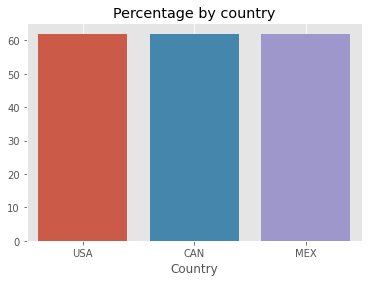

In [7]:
plt.style.use('ggplot')
sns.countplot(data['isocode'])
plt.xlabel('Country')
plt.ylabel("")
plt.title('Percentage by country')
plt.grid(None)
plt.show()

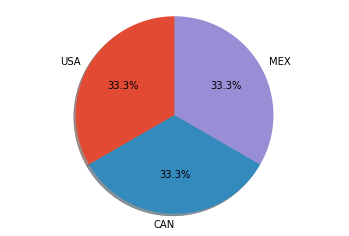

In [8]:
counts = data['isocode'].value_counts()/data.shape[0]*100
labels = list(data['isocode'].unique())
sizes = []
for i in range(0, len(counts)):
    sizes.append(counts[0:3][i])
sizes

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

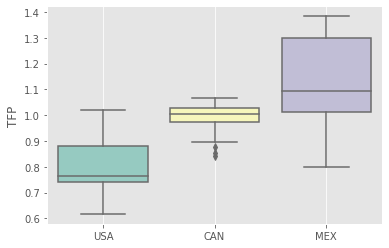

In [9]:
sns.boxplot(x=data['isocode'], y=data['rtfpna'], palette='Set3')
plt.xlabel("")
plt.ylabel("TFP")
plt.grid(None)
plt.show()
#do a statistical test to verify if there is significant difference between the countries.

In [10]:
pais = data[['isocode', 'rtfpna']]
pais_usa = pais.query('isocode == "USA"').drop('isocode',axis=1).dropna()
pais_can = pais.query('isocode == "CAN"').drop('isocode',axis=1).dropna()
pais_mex = pais.query('isocode == "MEX"').drop('isocode',axis=1).dropna()

In [11]:
# The Kruskal-Wallis test is a non-paranetric test to compare multiple samples
stats.kruskal(pais_usa,pais_can,pais_mex)

KruskalResult(statistic=109.29172071756341, pvalue=1.8518439512234706e-24)

The p-value is very small (less than alpha = 0.05), so we should reject the null hypothesis that all countries have the same distribution.

In [12]:
media = data.groupby('isocode')['rtfpna'].mean()
mediana = data.groupby('isocode')['rtfpna'].median()
desvio_padrao = data.groupby('isocode')['rtfpna'].std()

In [13]:
estats = pd.DataFrame({'media': mediana, 'mediana': media, 'desvio_padrao': desvio_padrao})
estats

,media,mediana,desvio_padrao
isocode,,,
CAN,1.004211,0.992886,0.050126
MEX,1.093859,1.130132,0.158209
USA,0.766047,0.803824,0.116121


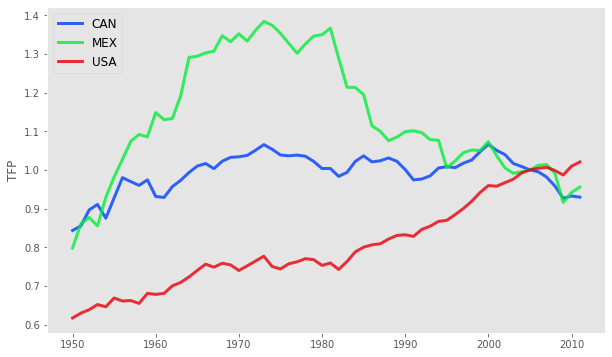

In [14]:
data = data.set_index(data.columns[1])
table = data.pivot(columns='isocode')
table.columns = [col[1] for col in table.columns]

plt.style.use('seaborn-bright')
plt.figure(figsize=(10,6))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8, label=c)
    plt.grid(None)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('TFP')
plt.show()

## Forecasts for 10 years

In [15]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
base = pd.read_csv('TFP.csv', parse_dates = ['year'], index_col = 'year',
                   date_parser = dateparse)
ts1 = base.query('isocode == "USA"')['rtfpna']
ts2 = base.query('isocode == "CAN"')['rtfpna']
ts3 = base.query('isocode == "MEX"')['rtfpna']


/home/renata/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In the graphs below, we have forecasts for ten years with 95% confidence, in the "tail" of the graph.

/home/renata/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/renata/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/renata/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/renata/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/renata/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params availa

<Figure size 432x288 with 0 Axes>

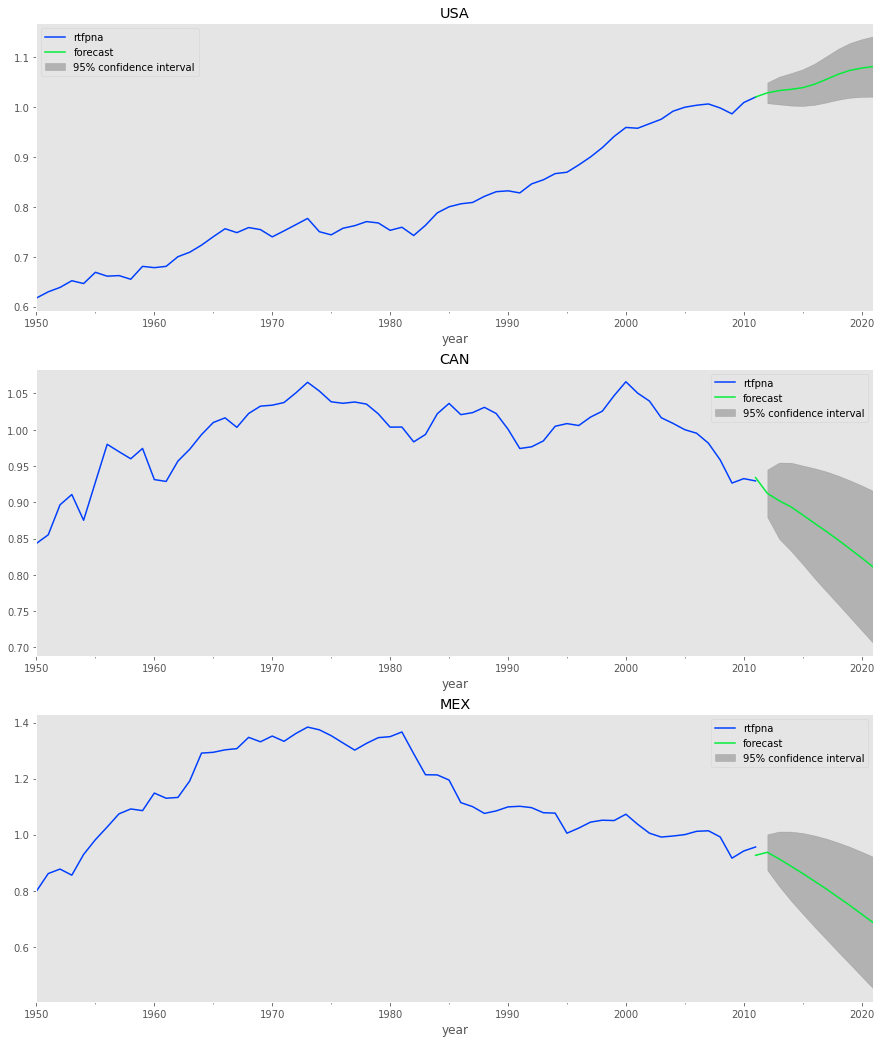

In [16]:
gs = gridspec.GridSpec(3, 1)
pl.figure()
plt.figure(figsize=(15,18))
ax = pl.subplot(gs[0, 0])
modelo1 = ARIMA(ts1, order=(2, 1, 2))
modelo_treinado1 = modelo1.fit()
previsoes1 = modelo_treinado1.forecast(steps = 10)[0]
eixo1 = ts1.plot()
modelo_treinado1.plot_predict('2011-01-01', '2021-01-01', ax=eixo1, plot_insample=False)
plt.title('USA')
plt.grid(None)

ax = pl.subplot(gs[1, 0])
modelo2 = ARIMA(ts2, order=(2, 2, 2))
modelo_treinado2 = modelo2.fit()
previsoes2 = modelo_treinado2.forecast(steps = 10)[0]
eixo2 = ts2.plot()
modelo_treinado2.plot_predict('2011-01-01', '2021-01-01', ax=eixo2, plot_insample=False)
plt.title('CAN')
plt.grid(None)

ax = pl.subplot(gs[2, 0])
modelo3 = ARIMA(ts3, order=(2, 2, 2))
modelo_treinado3 = modelo3.fit()
previsoes3 = modelo_treinado3.forecast(steps = 10)[0]
eixo3 = ts3.plot()
modelo_treinado3.plot_predict('2011-01-01', '2021-01-01', ax=eixo3, plot_insample=False)
plt.title('MEX')
plt.grid(None)

No handles with labels found to put in legend.


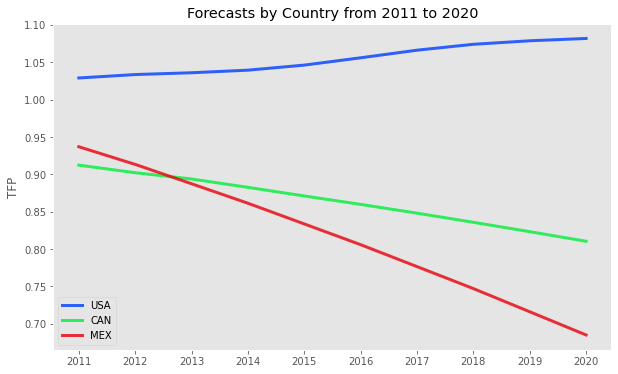

In [17]:
forecasts = [previsoes1, previsoes2, previsoes3]

plt.style.use('seaborn-bright')
plt.figure(figsize=(10,6))
for forecast in forecasts:
    plt.plot(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
              forecast, lw=3, alpha=0.8)
    plt.grid(None)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('TFP')
plt.legend(['USA', 'CAN', 'MEX'])
plt.title('Forecasts by Country from 2011 to 2020')
plt.show()

# Question 3

Some variables that could help to explain TFP series:

- 'rgdpna ' could help to explain TFP series. The more economically productive a country is, more outputs of all types it has;

- 'rkna': The more richness a country has, more resources it has to produce;

- 'csh_g': If government consumption is too high, extrapolating pre determined limit, it could reduce the resources available to different types of production;

- 'pl_m': A high price level of imports could decrease the money resources available for production, depending of the imports' volume.